In [4]:
from datetime import date, timedelta
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from dataset import StockPriceDataset
from model import StockPriceClassifier, StockPriceRegressor

%load_ext autoreload
%autoreload 2

In [5]:
# For deterministic results
np.random.seed(0)
torch.manual_seed(0)

tweet_data = pd.read_csv('data/tweets_anno_vader.csv', parse_dates=['date'])
stock_data = pd.read_csv('data/stocks.csv', parse_dates=['date'])

# Config variables
window_size = 3
min_tweets_per_instance = 1
train_ratio = 0.7
val_ratio = 0.15

num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-3
model_cfg = dict(
    input_size=6,
    gru_hidden_size=16,
    gru_num_layers=2
)

# Data setup
dataset = StockPriceDataset(tweet_data, stock_data, window_size=window_size, min_tweets_per_instance=min_tweets_per_instance)
train_size = int(train_ratio*len(dataset))
val_size = int(val_ratio*len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"found {len(dataset)} instances, making train/val/test split of {train_size}/{val_size}/{test_size}\n")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=None)
test_loader = DataLoader(test_dataset, batch_size=None)

found 514 instances, making train/val/test split of 359/77/78



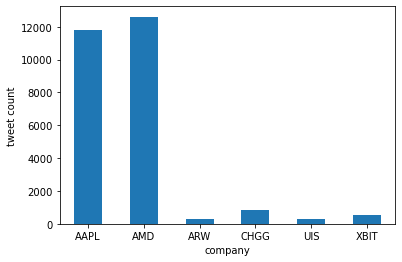

In [48]:
x = tweet_data['company']
plt.xlabel('company')
plt.ylabel('tweet count')
x.value_counts().sort_index().plot(kind='bar', rot=0)
plt.savefig('figures/company_counts.png')

neu    0.460925
pos    0.384218
neg    0.154857
dtype: float64

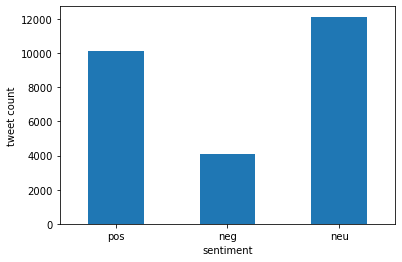

In [61]:
x = tweet_data['compound']
sent = pd.Series(['pos' if xi >= 0.05 else 'neg' if xi <= -0.05 else 'neu' for xi in x])
plt.xlabel('sentiment')
plt.ylabel('tweet count')
sent.value_counts().reindex(['pos', 'neg', 'neu']).plot(kind='bar', rot=0)
plt.savefig('figures/sent_counts.png')

sent.value_counts() / len(sent)

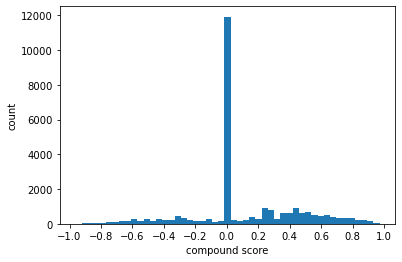

In [43]:
x = tweet_data['compound']
bins = np.linspace(x.min(), x.max(), 50)
plt.xticks(np.linspace(-1, 1, 11))
plt.xlabel('compound score')
plt.ylabel('count')
plt.hist(x, bins=bins)
plt.savefig('figures/compound_dist.png')

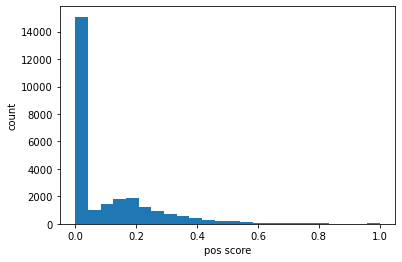

In [44]:
x = tweet_data['pos']
bins = np.linspace(x.min(), x.max(), 25)
plt.xticks(np.linspace(0, 1, 6))
plt.xlabel('pos score')
plt.ylabel('count')
plt.hist(x, bins=bins)
plt.savefig('figures/pos_dist.png')

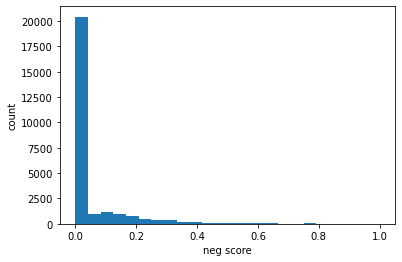

In [45]:
x = tweet_data['neg']
bins = np.linspace(x.min(), x.max(), 25)
plt.xticks(np.linspace(0, 1, 6))
plt.xlabel('neg score')
plt.ylabel('count')
plt.hist(x, bins=bins)
plt.savefig('figures/neg_dist.png')

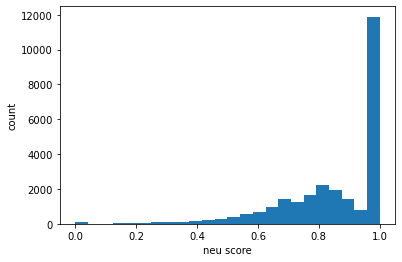

In [46]:
x = tweet_data['neu']
bins = np.linspace(x.min(), x.max(), 25)
plt.xticks(np.linspace(0, 1, 6))
plt.xlabel('neu score')
plt.ylabel('count')
plt.hist(x, bins=bins)
plt.savefig('figures/neu_dist.png')

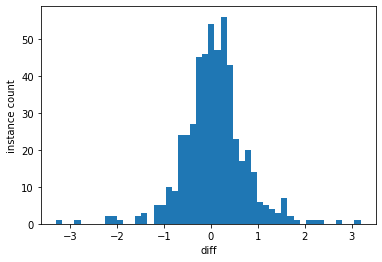

In [60]:
x = pd.Series([diff for _, _, diff in dataset])
plt.xlabel('diff')
plt.ylabel('instance count')
plt.xticks(np.linspace(-3, 3, 7))
plt.hist(x, bins=50)
plt.savefig('figures/diff_counts.png')